# Mastering PyTorch By Ashish Ranjan Jha

## Exploring GoogLeNet and Inception v3

GoogLeNet emerged as a radically different type of CNN architecture
that is composed of a module of parallel convolutional layers called the inception module. Because of this, GoogLeNet is also called Inception v1 (v1 marked the first version as more versions came along later). Some of the drastically new elements introduced by GoogLeNet were the following:
- The inception module – a module of several parallel convolutional layers
- Using 1x1 convolutions to reduce the number of model parameters
- Global average pooling instead of a fully connected layer – reduces overfitting
- Using auxiliary classifiers for training – for regularization and gradient stability GoogLeNet has 22 layers, which is more than the number of layers of any VGG model variant. Yet, due to some of the optimization tricks used, the number of parameters in GoogLeNet is 5 million, which is far less than the 138 million parameters of VGG. Let’s expand on some of the key features of this model.

### Inception Modules

One of the most significant contributions of this model is the introduction of a convolutional module that employs multiple convolutional layers running in parallel. These layers are eventually concatenated to form a single output vector. The parallel convolutional layers utilize different kernel sizes, such as 1x1, 3x3, and 5x5, allowing the model to capture visual information at various levels of detail from the image. In addition to these convolutions, a 3x3 max pooling layer further enhances feature extraction.

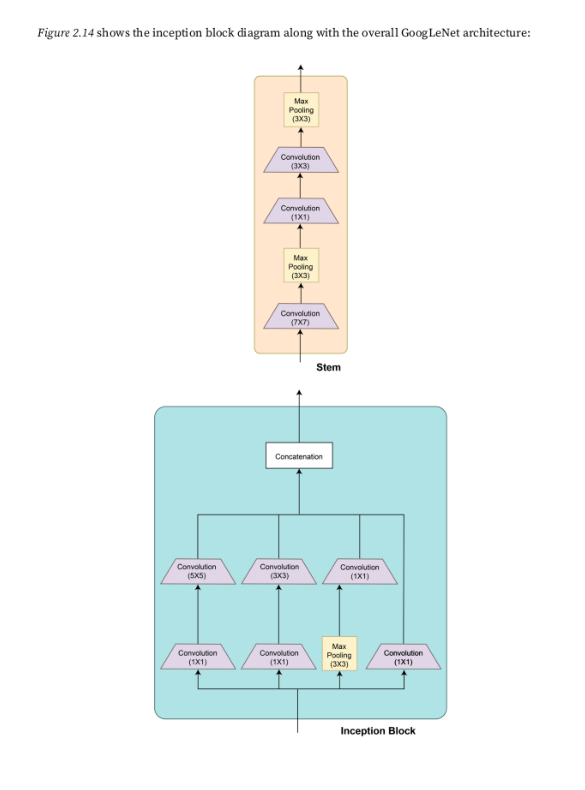

In [11]:
import matplotlib.pyplot as plt

img = plt.imread('/kaggle/input/inception-block-diagram/Inception Block Diagram.png')

plt.figure(figsize=(30,10))
plt.imshow(img)
plt.axis('off')
plt.show()

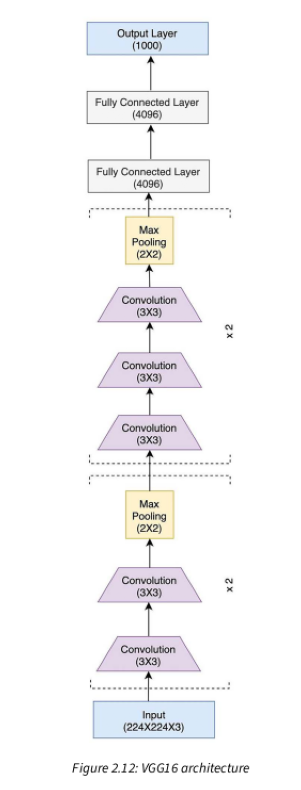

In [12]:
arch = plt.imread('/kaggle/input/vgg16-architecture/VGG16 Architecture')

plt.figure(figsize=(30,10))
plt.imshow(arch)
plt.axis('off')
plt.show()

Let's build the inception module by using this architecture diagram.

In [13]:
# Import dependencies
import torch 
import torch.nn as nn

In [14]:
class InceptionModule(nn.Module):
    def __init__(self, input_planes, n_channels1x1, 
                 n_channels3x3red, n_channels3x3, n_channels5x5red,
                 n_channels5x5, pooling_planes):
        """
        :param input_planes: Number of input channels (depth) of the feature map.
        :param n_channels1x1: Number of output channels for the 1x1 convolution branch.
        :param n_channels3x3red: Number of output channels for the 1x1 convolution in the 3x3 branch (used for depth reduction).
        :param n_channels3x3: Number of output channels for the 3x3 convolution branch.
        :param n_channels5x5red: Number of output channels for the 1x1 convolution in the 5x5 branch (used for depth reduction).
        :param n_channels5x5: Number of output channels for the 5x5 convolution branch (achieved through two 3x3 convolutions).
        :param pooling_planes: Number of output channels for the 1x1 convolution after the 3x3 max pooling branch.
        """
        
        # 1x1 convolution branch
        self.block1 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels1x1, kernel_size=1),# 1x1 convolution layer
            nn.BatchNorm2d(n_channels1x1),  
            nn.ReLU(True),  
        )
        
        # 1x1 convolution -> 3x3 convolution branch
        self.block2 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels3x3red, kernel_size=1), # 1x1 convolution to reduce depth
            nn.BatchNorm2d(n_channels3x3red),  
            nn.ReLU(True), 
            nn.Conv2d(n_channels3x3red, n_channels3x3, kernel_size=3, padding=1), # 3x3 convolution
            nn.BatchNorm2d(n_channels3x3),  
            nn.ReLU(True),  
        )
        
        # 1x1 convolution -> 5x5 convolution branch
        self.block3 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels5x5red, kernel_size=1),  # 1x1 convolution to reduce depth
            nn.BatchNorm2d(n_channels5x5red), 
            nn.ReLU(True),  
            nn.Conv2d(n_channels5x5red, n_channels5x5, kernel_size=3, padding=1),  # First 3x3 convolution (part of 5x5)
            nn.BatchNorm2d(n_channels5x5),  
            nn.ReLU(True),  
            nn.Conv2d(n_channels5x5, n_channels5x5, kernel_size=3, padding=1), # Second 3x3 convolution (part of 5x5)
            nn.BatchNorm2d(n_channels5x5),  
            nn.ReLU(True),   
        )
        
        # 3x3 max pooling -> 1x1 convolution branch
        self.block4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),  # 3x3 max pooling layer
            nn.Conv2d(input_planes, pooling_planes, kernel_size=1),  # 1x1 convolution after pooling
            nn.BatchNorm2d(pooling_planes),   
            nn.ReLU(True),   
        )

    def forward(self, ip):
        op1 = self.block1(ip)  # Forward pass through block1
        op2 = self.block2(ip)  # Forward pass through block2
        op3 = self.block3(ip)  # Forward pass through block3
        op4 = self.block4(ip)  # Forward pass through block4
        return torch.cat([op1, op2, op3, op4], 1)  # Concatenate outputs from all blocks along the channel dimension

### 1x1 convulations

In addition to the parallel convolutional layers in an inception module, each parallel layer has a preceding 1x1 convolutional layer. 1x1 convolutions primarily function as a tool for dimensionality reduction. While they do not alter the spatial dimensions (width and height) of the input image, they significantly impact the depth of the feature maps. This is particularly important in deep learning, where managing the number of channels (or depth) can lead to more efficient computations.
By applying a 1x1 convolution before the parallel layers of 3x3 and 5x5 convolutions, the model can effectively reduce the number of input channels. Reducing the number of parameters not only helps build a lighter model but also combats overfitting. 

Moreover, by reducing the input depth, the subsequent convolutional layers can focus on learning more relevant features without being overwhelmed by unnecessary information.

Let’s look at an example of a 1×1 convolution below:

For Example, If we want to perform 5×5 convolution having 48 filters without using 1×1 convolution as intermediate:

![wo1x1_convulation](https://media.geeksforgeeks.org/wp-content/uploads/20200429201100/without1x1.png)

Total Number of operations : (14 x 14 x 48) x (5 x 5 x 480) = 112.9 M

Now with 1x1 Convulation:

![w1x1_convulation](https://media.geeksforgeeks.org/wp-content/uploads/20200429201229/with1x1.png)

Total Number of operations: (14 x 14 x 16) x (1 x 1 x 480) + (14 x 14 x 48) x (5 x 5 x 16) = 1.5M + 3.8M = 5.3M which is much smaller than 112.9M.

[Example Source](https://www.geeksforgeeks.org/understanding-googlenet-model-cnn-architecture/)

### Global average pooling

The GoogLeNet architecture incorporates a 7x7 average pooling layer just before the penultimate output layer.  This layer takes a feature map of 7×7 and averages it to 1×1. This also decreases the number of trainable parameters to 0 and improves the top-1 accuracy by 0.6% The 7x7 average pooling layer in GoogLeNet serves a critical function by significantly reducing the model's parameter count and enhancing its robustness against overfitting. Without this layer, the model would have millions of additional parameters due to the dense connections of a fully connected layer.

### Auxiliary classifiers

Auxiliary classifiers are additional output branches incorporated into a deep neural network model to address the vanishing gradient problem, where gradients become very small during backpropagation, particularly in the early layers. This issue, common in deep networks, can hinder effective learning. By adding auxiliary classifiers at intermediate layers, the model receives extra gradient signals during training, ensuring that earlier layers continue to learn and adjust effectively. Besides combating the vanishing gradient problem, auxiliary classifiers also act as a form of regularization, helping to prevent overfitting by encouraging the model to learn more generalized features. These auxiliary branches are only active during training and are discarded during inference, ensuring they do not influence the final predictions but contribute significantly to the model's overall learning process.

In the context of GoogleNet, which introduced the Inception architecture, auxiliary classifiers play a crucial role in overcoming the challenges associated with training deep networks. GoogleNet is a 22-layer deep neural network, and as such, it is susceptible to the vanishing gradient problem, where gradients become too small to effectively train the earlier layers of the network during backpropagation. To address this, the designers of GoogleNet added auxiliary classifiers at intermediate points in the network, particularly after the Inception modules. These auxiliary classifiers produce their own predictions and contribute additional gradients during training, helping to ensure that the early layers of the network receive sufficient gradient signals to learn effectively.

In [1]:
import torch.nn as nn

class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        # Initial convolutional layer with batch normalization and ReLU activation
        self.stem = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),  # Convolutional layer: 3 input channels (RGB), 192 output channels
            nn.BatchNorm2d(192),                          # Batch normalization to stabilize and speed up training
            nn.ReLU(True),                              
        )
        
        # First Inception module
        # Parameters: input_channels, n_channels1x1, n_channels3x3red, n_channels3x3, n_channels5x5red, n_channels5x5, pooling_planes
        self.im1 = InceptionModule(192,  64,  96, 128, 16, 32, 32)  # 64 1x1, 96->128 3x3, 16->32 5x5, 32 pooling
        
        # Second Inception module
        self.im2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)  # 128 1x1, 128->192 3x3, 32->96 5x5, 64 pooling
        
        # Max pooling layer to reduce spatial dimensions (downsampling)
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)  
        
        # Third Inception module
        self.im3 = InceptionModule(480, 192,  96, 208, 16,  48,  64)  # 192 1x1, 96->208 3x3, 16->48 5x5, 64 pooling
        
        # Fourth Inception module
        self.im4 = InceptionModule(512, 160, 112, 224, 24,  64,  64)  # 160 1x1, 112->224 3x3, 24->64 5x5, 64 pooling
        
        # Fifth Inception module
        self.im5 = InceptionModule(512, 128, 128, 256, 24,  64,  64)  # 128 1x1, 128->256 3x3, 24->64 5x5, 64 pooling
        
        # Sixth Inception module
        self.im6 = InceptionModule(512, 112, 144, 288, 32,  64,  64)  # 112 1x1, 144->288 3x3, 32->64 5x5, 64 pooling
        
        # Seventh Inception module
        self.im7 = InceptionModule(528, 256, 160, 320, 32, 128, 128)  # 256 1x1, 160->320 3x3, 32->128 5x5, 128 pooling
        
        # Eighth Inception module
        self.im8 = InceptionModule(832, 256, 160, 320, 32, 128, 128)  # 256 1x1, 160->320 3x3, 32->128 5x5, 128 pooling
        
        # Ninth Inception module
        self.im9 = InceptionModule(832, 384, 192, 384, 48, 128, 128)  # 384 1x1, 192->384 3x3, 48->128 5x5, 128 pooling
        
        # Average pooling layer to reduce the spatial dimensions to 1x1
        self.average_pool = nn.AvgPool2d(7, stride=1)
        
        # Fully connected layer for classification (1000 classes, e.g., ImageNet)
        self.fc = nn.Linear(1024, 1000)

    def forward(self, ip):
        # Pass input through the initial convolutional layer
        op = self.stem(ip)
        
        # Pass output through the first Inception module
        out = self.im1(op)
        
        # Pass output through the second Inception module
        out = self.im2(op)
        
        # Downsample with max pooling
        op = self.max_pool(op)
        
        # Pass through the series of Inception modules (im3 to im7)
        op = self.im3(op)
        op = self.im4(op)
        op = self.im5(op)
        op = self.im6(op)
        op = self.im7(op)
        
        op = self.max_pool(op)
        
        # Pass through the final Inception modules (im8 and im9)
        op = self.im8(op)
        op = self.im9(op)
        
        # Apply average pooling to get a 1x1 spatial dimension
        op = self.average_pool(op)
        
        # Flatten the output for the fully connected layer
        op = op.view(op.size(0), -1)
        
        # Pass through the fully connected layer for final classification
        op = self.fc(op)
        
        return op

In [2]:
# Load a pretrained GoogLeNet
import torchvision.models as models 
model = models.googlenet(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 150MB/s]


Finally, a number of versions of the Inception model were developed later. One of the important model was Inception v3.